In [1]:
# Imports 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from keras import backend as K
import matplotlib.pyplot as plt 

In [2]:
# Import data
data = pd.read_csv("../../../data/mturk_experiment_2.csv",encoding='unicode_escape')
labels = data["Formality"]
samples = data["Sentence"]

# Testing with 90% training data
train_samples, test_samples, train_labels,test_labels = train_test_split(samples, labels, test_size=0.2,random_state=5)

train_samples = np.array(train_samples)
test_samples = np.array(test_samples)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [3]:
# Model setup

# Attention layer
class peel_the_layer(tf.keras.layers.Layer): 

    def __init__(self):    
        ##Nothing special to be done here
        super(peel_the_layer, self).__init__()

    def build(self, input_shape):
        ##Define the shape of the weights and bias in this layer
        ##This is a 1 unit layer. 
        units=1
        ##last index of the input_shape is the number of dimensions of the prev
        ##RNN layer. last but 1 index is the num of timesteps
        self.w=self.add_weight(name="att_weights", shape=(input_shape[-1], units), initializer="normal") #name property is useful for avoiding RuntimeError: Unable to create link.
        self.b=self.add_weight(name="att_bias", shape=(input_shape[-2], units), initializer="zeros")
        super(peel_the_layer,self).build(input_shape)

    def call(self, x):
        ##x is the input tensor..each word that needs to be attended to
        ##Below is the main processing done during training
        ##K is the Keras Backend import
        e = K.tanh(K.dot(x,self.w)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a

        ##return the ouputs. 'a' is the set of attention weights
        ##the second variable is the 'attention adjusted o/p state' or context
        return a, K.sum(output, axis=1)

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3'
tfhub_handle_preprocess =   'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
reshaped = tf.reshape(net,[-1, 768, 1])
lstm = tf.keras.layers.LSTM(512,return_sequences=True)(reshaped)
a, context = peel_the_layer()(lstm)

dense = tf.keras.layers.Dense(1)(context)
model = tf.keras.Model(text_input, dense)
model.summary()

loss = 'mse'
metrics = [tf.keras.metrics.MeanSquaredError(),tf.keras.losses.MeanAbsoluteError(),tf.keras.losses.MeanAbsolutePercentageError()]
optimiser = tf.optimizers.Adam(learning_rate= 5e-5)

model.compile(optimizer=optimiser, loss=loss, metrics=metrics)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'pooled_output': (N 108310273   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

In [4]:
# Results setup

results = pd.DataFrame()

In [5]:
def train_test(model, epochs, batch_size, results):
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2,min_delta=0.001)
    history = model.fit(x=train_samples,y=train_labels,batch_size=batch_size,epochs=epochs,verbose=2,callbacks=[callback])

    scores = model.evaluate(x=test_samples,y=test_labels)
    model_label = "Epochs - " + str(epochs) + " Batch Size - " + str(batch_size)

    results[model_label] = scores[1:]

    mse = history.history['mean_squared_error']

    plt.plot(mse)
    plt.title("Model: " + model_label)
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.ylim(bottom=0)
    plt.savefig(model_label + ".jpeg",dpi=100,bbox_inches='tight')

    return results

In [ ]:
results = train_test(model,20,32,results)
results = train_test(model,20,64,results)
results.T

In [ ]:
results = train_test(model,8,32,results)
results = train_test(model,8,64,results)
results.T

Epoch 1/4
88/88 - 3793s - loss: 6.5702 - mean_squared_error: 6.5702 - mean_absolute_error: 1.9321 - mean_absolute_percentage_error: 49.3468
Epoch 2/4
88/88 - 3855s - loss: 0.5006 - mean_squared_error: 0.5006 - mean_absolute_error: 0.5678 - mean_absolute_percentage_error: 15.9706
Epoch 3/4
88/88 - 3967s - loss: 0.3645 - mean_squared_error: 0.3645 - mean_absolute_error: 0.4821 - mean_absolute_percentage_error: 13.2452
Epoch 4/4
88/88 - 3948s - loss: 0.2272 - mean_squared_error: 0.2272 - mean_absolute_error: 0.3739 - mean_absolute_percentage_error: 10.1180
44/44 [==============================] - 236s 5s/step - loss: 0.5888 - mean_squared_error: 0.5888 - mean_absolute_error: 0.6039 - mean_absolute_percentage_error: 17.7375


,0,1,2
Epochs - 4 Batch Size - 64,0.588828,0.603943,17.737452


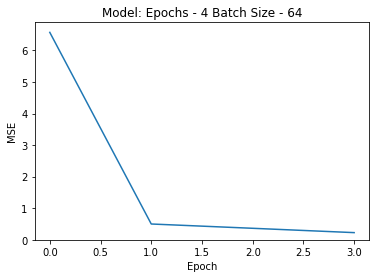

In [6]:
#results = train_test(model,4,32,results)
results = train_test(model,4,64,results)
results.T

Epoch 1/3
176/176 - 3102s - loss: 0.1778 - mean_squared_error: 0.1778 - mean_absolute_error: 0.3269 - mean_absolute_percentage_error: 8.8015
Epoch 2/3
176/176 - 3075s - loss: 0.1368 - mean_squared_error: 0.1368 - mean_absolute_error: 0.2910 - mean_absolute_percentage_error: 7.9458
Epoch 3/3
176/176 - 3081s - loss: 0.0852 - mean_squared_error: 0.0852 - mean_absolute_error: 0.2267 - mean_absolute_percentage_error: 6.1219
44/44 [==============================] - 231s 5s/step - loss: 0.5189 - mean_squared_error: 0.5189 - mean_absolute_error: 0.5780 - mean_absolute_percentage_error: 15.6377
Epoch 1/3
88/88 - 3974s - loss: 0.0533 - mean_squared_error: 0.0533 - mean_absolute_error: 0.1775 - mean_absolute_percentage_error: 4.8248
Epoch 2/3
88/88 - 4030s - loss: 0.0293 - mean_squared_error: 0.0293 - mean_absolute_error: 0.1326 - mean_absolute_percentage_error: 3.6142
Epoch 3/3
88/88 - 4045s - loss: 0.0239 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1199 - mean_absolute_percentage_erro

,0,1,2
Epochs - 4 Batch Size - 64,0.588828,0.603943,17.737452
Epochs - 3 Batch Size - 32,0.518949,0.577952,15.637679
Epochs - 3 Batch Size - 64,0.538889,0.583302,16.616337


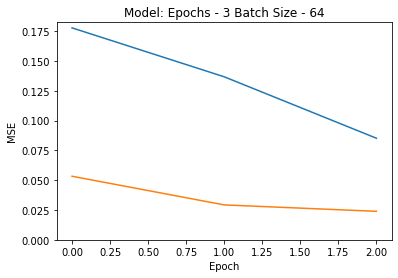

In [7]:
results = train_test(model,3,32,results)
results = train_test(model,3,64,results)
results.T

Epoch 1/2
176/176 - 2824s - loss: 0.0263 - mean_squared_error: 0.0263 - mean_absolute_error: 0.1273 - mean_absolute_percentage_error: 3.4700
Epoch 2/2
176/176 - 2782s - loss: 0.0407 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 4.3468
44/44 [==============================] - 210s 5s/step - loss: 0.5393 - mean_squared_error: 0.5393 - mean_absolute_error: 0.5863 - mean_absolute_percentage_error: 16.5070
Epoch 1/2
88/88 - 3519s - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1437 - mean_absolute_percentage_error: 3.9256
Epoch 2/2
88/88 - 3542s - loss: 0.0203 - mean_squared_error: 0.0203 - mean_absolute_error: 0.1125 - mean_absolute_percentage_error: 3.0820
44/44 [==============================] - 211s 5s/step - loss: 0.5420 - mean_squared_error: 0.5420 - mean_absolute_error: 0.5866 - mean_absolute_percentage_error: 16.5969


,0,1,2
Epochs - 4 Batch Size - 64,0.588828,0.603943,17.737452
Epochs - 3 Batch Size - 32,0.518949,0.577952,15.637679
Epochs - 3 Batch Size - 64,0.538889,0.583302,16.616337
Epochs - 2 Batch Size - 32,0.539272,0.586305,16.506973
Epochs - 2 Batch Size - 64,0.542049,0.586643,16.596861


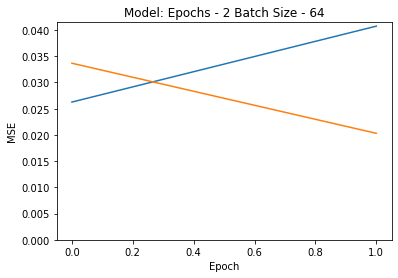

In [8]:
results = train_test(model,2,32,results)
results = train_test(model,2,64,results)
results.T

176/176 - 2869s - loss: 0.0195 - mean_squared_error: 0.0195 - mean_absolute_error: 0.1096 - mean_absolute_percentage_error: 3.0161
44/44 [==============================] - 231s 5s/step - loss: 0.5413 - mean_squared_error: 0.5413 - mean_absolute_error: 0.5860 - mean_absolute_percentage_error: 16.7649
88/88 - 4029s - loss: 0.0220 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1168 - mean_absolute_percentage_error: 3.1691
44/44 [==============================] - 348s 8s/step - loss: 0.5570 - mean_squared_error: 0.5570 - mean_absolute_error: 0.5962 - mean_absolute_percentage_error: 17.3562


,0,1,2
Epochs - 4 Batch Size - 64,0.588828,0.603943,17.737452
Epochs - 3 Batch Size - 32,0.518949,0.577952,15.637679
Epochs - 3 Batch Size - 64,0.538889,0.583302,16.616337
Epochs - 2 Batch Size - 32,0.539272,0.586305,16.506973
Epochs - 2 Batch Size - 64,0.542049,0.586643,16.596861
Epochs - 1 Batch Size - 32,0.541327,0.586028,16.764856
Epochs - 1 Batch Size - 64,0.557036,0.596244,17.356215


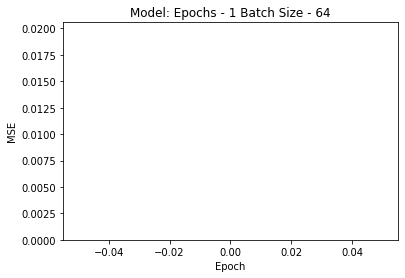

In [9]:
results = train_test(model,1,32,results)
results = train_test(model,1,64,results)
results.T

In [11]:
results = results.T
results.to_csv("../../../data/random_state_five/bert_italian_sentences_scores.csv")
results

,Epochs - 4 Batch Size - 64,Epochs - 3 Batch Size - 32,Epochs - 3 Batch Size - 64,Epochs - 2 Batch Size - 32,Epochs - 2 Batch Size - 64,Epochs - 1 Batch Size - 32,Epochs - 1 Batch Size - 64
0,0.588828,0.518949,0.538889,0.539272,0.542049,0.541327,0.557036
1,0.603943,0.577952,0.583302,0.586305,0.586643,0.586028,0.596244
2,17.737452,15.637679,16.616337,16.506973,16.596861,16.764856,17.356215
